# Genetic Algorithm Testing

## Load Env

In [1]:
import sys
from pathlib import Path
import json

# Add project root to Python path
project_root = Path().resolve().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

project_root

WindowsPath('C:/Users/weinbendera/Repos/FJSSP Research/NEW-FJSSP-Research')

In [5]:
from utils.input_schemas import ProductRequest

product_requests = [
    ProductRequest(product='WOVEN LABEL OURELA FABRIC', amount=2, deadline=None),
    # ProductRequest(product='ESTORE RIBBON', amount=2, deadline=None),
    # ProductRequest(product='GORGORÃO RIBBON', amount=1, deadline=None),
    # ProductRequest(product='TAFFETA EMBLEM', amount=1, deadline=None),
    # ProductRequest(product='PRINTED RIBBON', amount=1, deadline=None),
    # ProductRequest(product='ROK ELASTIC', amount=3, deadline=None),
    # ProductRequest(product='BRAIDED ELASTIC', amount=1, deadline=None),
    # ProductRequest(product='SMOOTH ELASTIC(A)', amount=1, deadline=None),
    # ProductRequest(product='STRAP W/ STRIPES', amount=0, deadline=None),
]

In [6]:
import json

from utils.input_schemas import ProductRequest, EnergySource
from utils.job_builder import JobBuilder
from utils.factory_logic_loader import FactoryLogicLoader

steps = 1152

data_file = project_root / "data" / "Input_JSON_Schedule_Optimization.json"
with open(data_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

energy_sources = [EnergySource(**es) for es in data["energy_sources"]]

# product_requests_data = data["product_requests"]
# product_requests = [ProductRequest(**pr) for pr in product_requests_data]

factory_logic = FactoryLogicLoader.load_from_file(filepath=str(data_file))
job_builder = JobBuilder(factory_logic=factory_logic)
jobs = job_builder.build_jobs(product_requests=product_requests)

total_operations = sum(len(job.operations) for job in jobs)
print(f"Total operations: {total_operations}")
product_requests

Total operations: 8


[ProductRequest(product='WOVEN LABEL OURELA FABRIC', amount=2, deadline=None)]

Using energy-aware objective (solar offset + time-varying grid prices)

Solving with OR-Tools CP-SAT (max time: 300s)...
Solve time: 2.63s
Status: OPTIMAL

OPTIMAL solution found:
  Operations scheduled: 8
  Makespan: 32
  Energy cost: $3.37
Makespan: 32
Energy Cost: $3.37
Feasible: True
Operations: 8


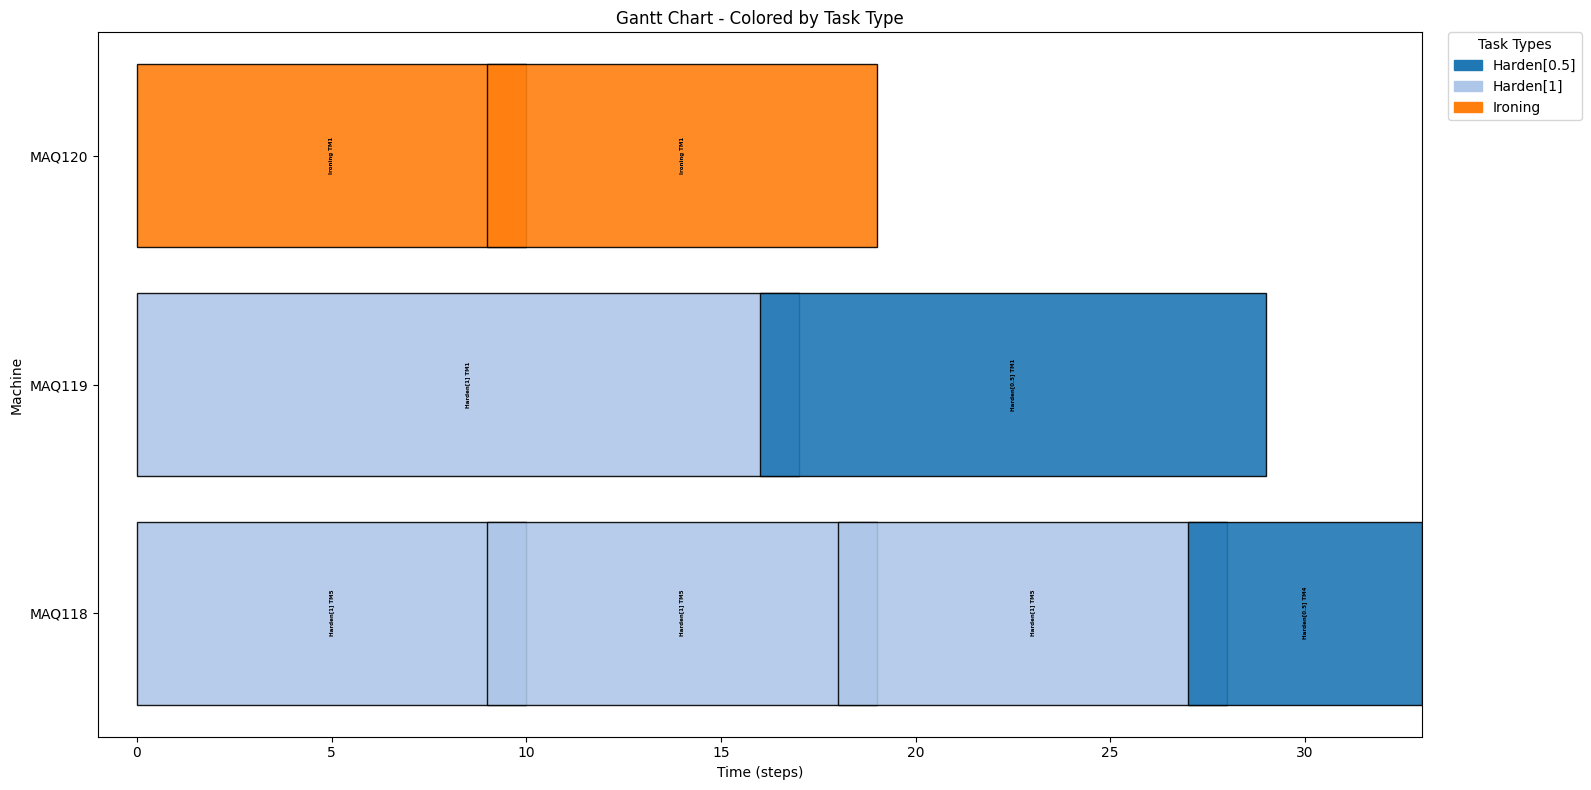

In [7]:
from schedulers.or_scheduler.or_scheduler import ORToolsScheduler

ortools_scheduler = ORToolsScheduler(
    factory_logic=factory_logic,
    max_solve_time_seconds=300,
    cost_weight=1.0,
    makespan_weight=0.1,
    use_energy_optimization=True  # Enable solar/grid pricing
)

schedule = ortools_scheduler.schedule(jobs, energy_sources)

# Access schedule data
print(f"Makespan: {schedule.makespan}")
print(f"Energy Cost: ${schedule.energy_cost:.2f}")
print(f"Feasible: {schedule.is_feasible}")
print(f"Operations: {len(schedule.operations)}")

schedule.plot_gantt_by_task()

## Compare Original Paper's GA

In [ ]:
import pandas as pd
import numpy as np

output_file = project_root / "data" / "Output_JSON_Schedule_Optimization.json"
with open(output_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from typing import Literal, Dict, List
import pandas as pd


def count_operations_from_json(schedule_data: Dict) -> Dict:
    """
    Count and analyze operations from JSON schedule data.
    
    Args:
        schedule_data: Dictionary with 'cell_schedules' from JSON output
        
    Returns:
        Dictionary with operation counts and statistics
    """
    cell_schedules = schedule_data.get('cell_schedules', [])
    
    # Initialize counters
    total_operations = 0
    product_counts = {}
    task_counts = {}
    machine_counts = {}
    cell_counts = {}
    
    # Collect all operations
    all_operations = []
    
    for cell_schedule in cell_schedules:
        cell_name = cell_schedule.get('cell', 'unknown')
        cell_counts[cell_name] = 0
        
        for machine_data in cell_schedule.get('machines', []):
            machine_id = machine_data.get('machine', 'unknown')
            assignments = machine_data.get('assignments', [])
            
            machine_counts[machine_id] = len(assignments)
            cell_counts[cell_name] += len(assignments)
            total_operations += len(assignments)
            
            for assignment in assignments:
                task = assignment.get('task', 'Unknown')
                product = assignment.get('product_finished', 'Unknown')
                
                # Count by product
                product_counts[product] = product_counts.get(product, 0) + 1
                
                # Count by task
                task_counts[task] = task_counts.get(task, 0) + 1
                
                # Store operation info
                all_operations.append({
                    'cell': cell_name,
                    'machine': machine_id,
                    'task': task,
                    'product': product,
                    'start': assignment.get('start', 0),
                    'task_mode': assignment.get('task_mode', '')
                })
    
    # Calculate machine utilization (if makespan info available)
    makespan = 0
    if all_operations:
        # Estimate makespan from latest operation
        # Note: This is an estimate without knowing exact durations
        makespan = max(op['start'] for op in all_operations) + 20  # rough estimate
    
    return {
        'total_operations': total_operations,
        'operations_by_product': product_counts,
        'operations_by_task': task_counts,
        'operations_by_machine': machine_counts,
        'operations_by_cell': cell_counts,
        'estimated_makespan': makespan,
        'all_operations': all_operations
    }


def print_operation_statistics(schedule_data: Dict) -> None:
    """
    Print formatted statistics about operations in the schedule.
    
    Args:
        schedule_data: Dictionary with 'cell_schedules' from JSON output
    """
    stats = count_operations_from_json(schedule_data)
    
    print("="*80)
    print("OPERATION STATISTICS (from JSON output)")
    print("="*80)
    
    print(f"\n📊 Overall Metrics:")
    print(f"  Total Operations: {stats['total_operations']}")
    print(f"  Estimated Makespan: ~{stats['estimated_makespan']} steps")
    
    print(f"\n📦 Operations by Product:")
    for product, count in sorted(stats['operations_by_product'].items(), key=lambda x: x[1], reverse=True):
        percentage = (count / stats['total_operations'] * 100) if stats['total_operations'] > 0 else 0
        print(f"  {product}: {count} operations ({percentage:.1f}%)")
    
    print(f"\n⚙️  Operations by Task:")
    for task, count in sorted(stats['operations_by_task'].items(), key=lambda x: x[1], reverse=True):
        percentage = (count / stats['total_operations'] * 100) if stats['total_operations'] > 0 else 0
        print(f"  {task}: {count} operations ({percentage:.1f}%)")
    
    print(f"\n🏭 Operations by Machine:")
    for machine, count in sorted(stats['operations_by_machine'].items()):
        print(f"  {machine}: {count} operations")
    
    print(f"\n🏢 Operations by Cell:")
    for cell, count in sorted(stats['operations_by_cell'].items()):
        print(f"  {cell}: {count} operations")
    
    print("="*80)


def plot_gantt_chart(
    schedule_data: Dict,
    factory_logic=None,
    color_by: Literal['product', 'task'] = 'product',
    figsize: tuple = (20, 10),
    title: str = "Gantt Chart"
) -> tuple:
    """
    Plot a Gantt chart from scheduling data.
    
    Args:
        schedule_data: Dictionary with 'cell_schedules' containing machines and assignments
        factory_logic: Optional FactoryLogic object to look up task mode durations
        color_by: Color by 'product' or 'task' (default: 'product')
        figsize: Figure size tuple
        title: Chart title
        
    Returns:
        Tuple of (fig, ax) matplotlib objects
    """
    # Extract data
    cell_schedules = schedule_data.get('cell_schedules', [])
    
    # Prepare data for plotting
    machines = []
    tasks_data = []
    colors = []
    
    # Determine what to color by
    if color_by == 'product':
        # Color map for different products
        color_items = {}
        legend_title = 'Product Type'
    else:  # color_by == 'task'
        # Color map for different tasks
        color_items = {}
        legend_title = 'Task Type'
    
    color_palette = plt.cm.tab20(np.linspace(0, 1, 20))
    color_idx = 0
    
    for cell_schedule in cell_schedules:
        cell_name = cell_schedule.get('cell', 'unknown')
        for machine_data in cell_schedule.get('machines', []):
            machine_id = machine_data.get('machine', 'unknown')
            assignments = machine_data.get('assignments', [])
            
            # Sort assignments by start time
            assignments = sorted(assignments, key=lambda x: x.get('start', 0))
            
            for i, assignment in enumerate(assignments):
                start = assignment.get('start', 0)
                task = assignment.get('task', 'Unknown')
                task_mode = assignment.get('task_mode', '')
                product_finished = assignment.get('product_finished', 'Unknown')
                
                # Calculate duration
                duration = None
                
                # Method 1: Use next assignment's start time (if available)
                if i < len(assignments) - 1:
                    next_start = assignments[i + 1].get('start', start)
                    duration = next_start - start
                else:
                    # Method 2: Look up task_mode duration from factory_logic
                    if factory_logic and task_mode:
                        try:
                            task_mode_obj = factory_logic.get_task_mode(task_mode)
                            duration = len(task_mode_obj.power)
                        except (KeyError, AttributeError):
                            duration = 10  # Default fallback
                    else:
                        duration = 10  # Default fallback
                
                # Create label
                label = f"{task_mode}" if task_mode else task
                
                # Determine what to color by
                if color_by == 'product':
                    color_key = product_finished
                else:  # color_by == 'task'
                    color_key = task
                
                # Get or assign color for this item
                if color_key not in color_items:
                    color_items[color_key] = color_palette[color_idx % len(color_palette)]
                    color_idx += 1
                
                machines.append(f"{machine_id}\n({cell_name})")
                tasks_data.append({
                    'start': start,
                    'duration': duration,
                    'label': label,
                    'task': task,
                    'product': product_finished
                })
                colors.append(color_items[color_key])
    
    if not machines:
        print("No operations to plot.")
        return None, None
    
    # Create unique machine list with order preserved
    unique_machines = []
    seen = set()
    for m in machines:
        if m not in seen:
            unique_machines.append(m)
            seen.add(m)
    
    # Create y positions for machines
    machine_to_y = {m: i for i, m in enumerate(unique_machines)}
    
    # Prepare data for plotting
    y_positions = []
    starts = []
    durations = []
    labels = []
    plot_colors = []
    
    for i, machine in enumerate(machines):
        y_positions.append(machine_to_y[machine])
        starts.append(tasks_data[i]['start'])
        durations.append(tasks_data[i]['duration'])
        labels.append(tasks_data[i]['label'])
        plot_colors.append(colors[i])
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot bars
    bars = ax.barh(
        y_positions,
        durations,
        left=starts,
        color=plot_colors,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5
    )
    
    # Add labels to bars (if space allows)
    for i, (bar, label) in enumerate(zip(bars, labels)):
        width = bar.get_width()
        if width > 5:  # Only add label if bar is wide enough
            ax.text(
                bar.get_x() + width/2,
                bar.get_y() + bar.get_height()/2,
                label,
                ha='center',
                va='center',
                fontsize=6,
                rotation=90,
                weight='bold'
            )
    
    # Set y-axis
    ax.set_yticks(range(len(unique_machines)))
    ax.set_yticklabels(unique_machines, fontsize=9)
    ax.invert_yaxis()  # Top to bottom
    
    # Set labels and title
    ax.set_xlabel('Time Step', fontsize=12)
    ax.set_ylabel('Machine', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, axis='x', alpha=0.3, linestyle='--')
    
    # Create legend
    legend_elements = [
        mpatches.Patch(facecolor=color, label=str(item), alpha=0.7)
        for item, color in sorted(color_items.items())
    ]
    ax.legend(
        handles=legend_elements,
        loc='upper right',
        bbox_to_anchor=(1.15, 1),
        title=legend_title,
        fontsize=8
    )
    
    plt.tight_layout()
    return fig, ax


def operations_to_dataframe(schedule_data: Dict) -> pd.DataFrame:
    """
    Convert JSON schedule data to pandas DataFrame.
    
    Args:
        schedule_data: Dictionary with 'cell_schedules' from JSON output
        
    Returns:
        DataFrame with all operations
    """
    stats = count_operations_from_json(schedule_data)
    return pd.DataFrame(stats['all_operations'])

In [ ]:
import json
from pathlib import Path


# Print operation statistics
print_operation_statistics(data)

# Plot colored by task
fig2, ax2 = plot_gantt_chart(
    data,
    factory_logic=factory_logic,
    color_by='task',
    title="Original Paper Schedule - By Task"
)
plt.show()

# Convert to DataFrame for analysis
df = operations_to_dataframe(data)
print(df.head())
print(f"\nDataFrame shape: {df.shape}")

# Analyze with pandas
print("\nOperations per machine:")
print(df.groupby('machine').size().sort_values(ascending=False))

print("\nOperations per product:")
print(df.groupby('product').size().sort_values(ascending=False))

print("\nOperations per task:")
print(df.groupby('task').size().sort_values(ascending=False))